# Predict wine quality with Regularization

I am using the Wine Quality Dataset to classify a wine quality as good (>5 rating) or bad (<=5 rating). The goals of this project are to:
- implement different logistic regression classifiers
- find the best ridge-regularized classifier using hyperparameter tuning
- implement a tuned lasso-regularized feature selection method

**Data source:** The data for the project is the Wine Quality Dataset from [Kaggle](https://www.kaggle.com/datasets/yasserh/wine-quality-dataset). 

The features in the dataset are the following:
- 11 input variables (based on physicochemical tests): 
    - ‘fixed acidity’, 
    - ‘volatile acidity’, 
    - ‘citric acid’, 
    - ‘residual sugar’,
    - ’chlorides’, 
    - ‘free sulfur dioxide’, 
    - ‘total sulfur dioxide’, 
    - ‘density’, 
    - ‘pH’, 
    - ‘sulphates’,
    - ‘alcohol’.
- An output variable: ‘quality’ (0 for bad and 1 for good)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('/kaggle/input/wine-quality-dataset/WineQT.csv')
print(df.shape)
df.head()

(1143, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [3]:
# Drop Id column
df = df.drop(columns=['Id'])
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
# Define features and y
features = df.drop(columns = ['quality'])
y = (df['quality'] > 5)*1                    # original quality is in scale 1-10 but here I make it binary for the the sake of the project
y.head()

0    0
1    0
2    0
3    1
4    0
Name: quality, dtype: int64

# Logistic Regression Classifier without Regularization

In [5]:
# Standardize data
X = StandardScaler().fit_transform(features)

# Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=99)

# Define logistic regression classifier without regularization
lr_no_reg = LogisticRegression()

# Fit model with data
lr_no_reg.fit(X_train, y_train)

LogisticRegression()

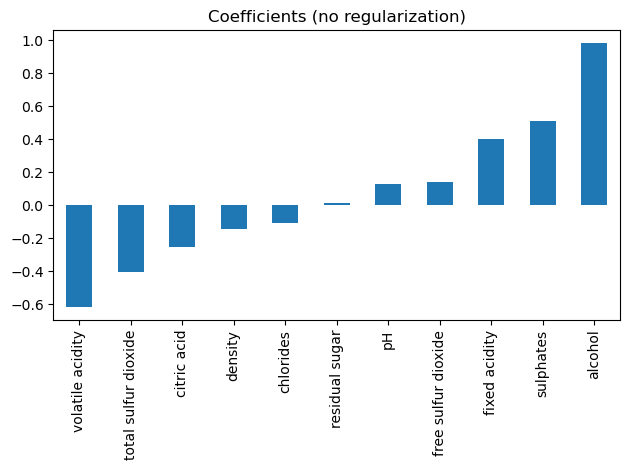

In [6]:
# Plot the coefficients obtained from the model
predictors = features.columns
coefficients = lr_no_reg.coef_.ravel()                 # ravel() returns a flattened array
coef = pd.Series(coefficients, predictors).sort_values()

coef.plot(kind='bar', title='Coefficients (no regularization)')
plt.tight_layout()
plt.show()

For classifiers, it is important that the classifier not only has high accuracy, but also high precision and recall, i.e., a low false positive and false negative rate.

A metric known as f1 score, which is the weighted mean of precision and recall, captures the performance of a classifier holistically. It takes values between 0 and 1 and the closer it is to 1, the better the classifier.

In [7]:
y_pred_train = lr_no_reg.predict(X_train)
y_pred_test = lr_no_reg.predict(X_test)

f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)

print(f'f1 score for training data (no regularization): {f1_train}')
print(f'f1 score for test data (no regularization): {f1_test}')

f1 score for training data (no regularization): 0.7826982492276003
f1 score for test data (no regularization): 0.7258064516129032


# Logistic Regression with L2 Regularization

Let's see what is the range of C we need to have good regularization.

In [8]:
# Write function to collect f1 scores for train and test data while C varies in a logistic regression model
C_array = [0.0001, 0.001, 0.01, 0.1, 1]
train_array = []
test_array = []

for x in C_array:
    lr = LogisticRegression(C = x, random_state=99)
    lr.fit(X_train, y_train)
    y_pred_train = lr.predict(X_train)
    y_pred_test = lr.predict(X_test)
    train_array.append(f1_score(y_train, y_pred_train))
    test_array.append(f1_score(y_test, y_pred_test))

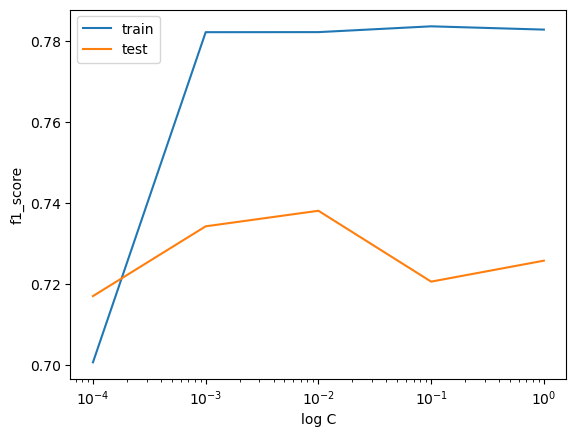

In [9]:
# Plot how f1 scores change while changing parameter C in logistic regression model
plt.plot(C_array,train_array)
plt.plot(C_array,test_array)
plt.xlabel('log C')
plt.ylabel('f1_score')
plt.legend(labels=['train', 'test'])
plt.xscale('log')
plt.show()

Looks like the optimal C seems to be somewhere around 0.001, so let's set up the search window between 0.0001 and 0.01.

In [10]:
C_array = np.logspace(-4, -2, 100)                         # searching between -4 and -2 because it's log (log₁₀(0.0001) = -4)
lr_l2_reg = LogisticRegressionCV(Cs = C_array,
                                penalty = 'l2',            # here I am using Ridge regularization (L2)
                                scoring='f1', 
                                cv=5,                      # 5-fold cross validation method
                                random_state=99)

lr_l2_reg.fit(X_train, y_train)

print('Best C: ', lr_l2_reg.C_)
print('Best score: ', lr_l2_reg.scores_[1].mean(axis=0).max())

Best C:  [0.00343047]
Best score:  0.7870042217280384


In [11]:
lr_best_ridge = LogisticRegression(C = lr_l2_reg.C_[0])
lr_best_ridge.fit(X_train, y_train)

y_pred_test = lr_best_ridge.predict(X_test)

print(f'f1 score for test data (L2 regularization): {f1_score(y_test, y_pred_test)}')

f1 score for test data (L2 regularization): 0.7286821705426355


# Feature Selection using L1 Regularization

In [12]:
C_array = np.logspace(-4, 2, 100)                         # searching between C=0.01 and 100
lr_l1_reg = LogisticRegressionCV(Cs = C_array,
                                penalty = 'l1',
                                solver='liblinear',
                                scoring='f1', 
                                cv=5,
                                random_state=99)
lr_l1_reg.fit(X, y)

print('Best C: ', lr_l1_reg.C_)

Best C:  [0.14174742]


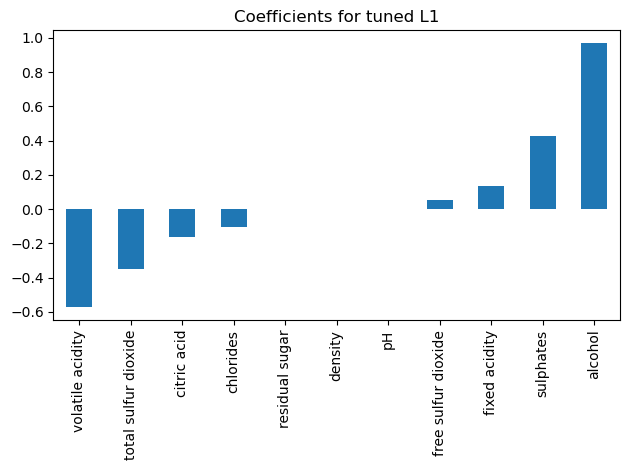

In [13]:
# Plot the coefficients obtained from the model
coefficients = lr_l1_reg.coef_.ravel()                 
coef = pd.Series(coefficients, predictors).sort_values()

coef.plot(kind='bar', title='Coefficients for tuned L1')
plt.tight_layout()
plt.show()